# Basic classifier with TensorFlow

## What is TensorFlow?

TensorFlow™ is an open source library developed by Google, for high performance numerical computation which has become mainstream within the Deep Learning community. The basic architecture of Tensorflow could be summarized as follows: 

- Operations are defined (layers of the neural network, sums, multiplications, optimizers ...) as nodes of a graph. 

- The data is in the form of a tensor. These tensors go through the nodes of the graph, where the defined operations are executed on them (hence the name TensorFlow). 

- Once the graph and the input tensors have been defined, the entire process described above is executed in a Session.

If you would like to get a better idea of how TensorFlow works, we highly reccomed you to read the following article:

<a href="https://medium.com/@camrongodbout/tensorflow-in-a-nutshell-part-one-basics-3f4403709c9d">TensorFlow in a nutshell</a>

You could also refer to the <a href="https://www.tensorflow.org">official TensorFlow web page</a> for more information, tutorials and instalation guides.

This basic classifier tutorial is based on the official TensorFlow tutorial, we have added some additional concepts such as the Datasets API and the Monitored Training Session. This is because we will need those concepts in the more advanced tutorials and we hope showing them here will make the series easier to follow.

## Why only TensorFlow and not keras?

TensorFlow incorporates a high level module called keras. It simplifies the usage a TensorFlow to a great extent.

These tutorials could also use Keras, but native TensorFlow is more transparent allowing us to demonstrate more easily all the steps and decisions that are taken in the creation of the graph. We will only use Keras to import the data and define the cost function for convenience.

## First step: import libraries

The first one to be imported will be tensorflow, which by agreement is usually given the abbreviated name of tf.

Although we really do not need to do to import keras (we could use it from tf.keras) we will also import it separately for convenience.

Finally, three traditional basic Python libraries: numpy, matplotlib and time.

In the next cell, we also define some basic constant variables for our algorithm. The number of epochs to train and the size of the batches we are going to use for trainning.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

## Load and normalize the data

We are going to work with a database called fashion mnist kindly put together by Zalando to substitute the more traditional handwritten digit database. It contains photographs consisting of 28x28 pixels in black and white of 10 different types of clothing. The features on which we will train our model will be the values of each pixel, ranging from 0 to 255.

After loading we will divide these values by 255 so that they are normalized between 0 and 1.

We have also added a list with the names of the different types of clothing, so that we can visualize the images with their names later on.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('Data loaded')
print('Local dataset size: {}'.format(train_images.shape[0]))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0
test_images = test_images / 255.0

## Global Step

Next we create a global step for the optimizer. This is a variable that increases every time the parameters of the model are updated. It is not necessary to create it always in TensorFlow, and it could also be created as a normal variable. However, by creating it through this function we guarantee that any other function that requires the global step will find it through its standardized name (a name that the variable carries below, its context or name scope). In addition, the function checks if a global step already exists, and it associates it with this variable instead of creating a new one.

In [ ]:
global_step = tf.train.get_or_create_global_step()

## Start to build the graph. Order it through name_scope.

Getting a little bit ahead of ourselves, here we show a Tensorboard visualization of the final graph we will build in this tutorial. Notice that all operations are nicely arranged and it is easy to see the different elements of our neural network:

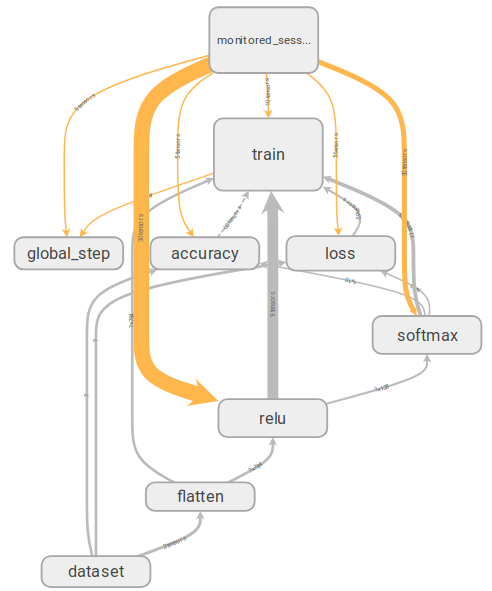

If we are not careful while defining our graph, each operation we add would be represented by a single node and the final visualization could end up being a rather confusing tangle.

To avoid this, we will make use of the Context Manager tensorflow provides, the name_scope. Through name_scopes we will be able to merge operations together and visualize them as single blocks with Tensorboard. This will also force us to think on the structure of the graph will we code our neural network.

In the next cell, we group every node related with data inputs into a single name_scope called 'dataset'.

In [ ]:
with tf.name_scope('dataset'):
    images_placeholder = tf.placeholder(train_images.dtype, [None, train_images.shape[1], train_images.shape[2]])
    labels_placeholder = tf.placeholder(train_labels.dtype, [None])
    batch_size = tf.placeholder(tf.int64)

    dataset = tf.data.Dataset.from_tensor_slices((images_placeholder, labels_placeholder))
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat(EPOCHS)
    iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
    dataset_init_op = iterator.make_initializer(dataset, name='dataset_init')
    X, y = iterator.get_next()

### Placeholders

Placeholders are a way to initialize variables, without giving them a value, or even a certain shape if you do not want to. We simply create a structure, to which we tell what kind of data it will contain, and the dimensions that we know. For example, the first of them represents the image database. We know that the type of data that will contain will be the same as that of the images. In terms of its dimensions we know what dimension each image has (2nd and 3rd placeholder dimension) but we do not know how many images there will be (first dimension of the placeholder), by putting a <b>None</b> we are letting it know that in that dimension there can be any number of elements.

This type of variables serve as input for operations that we define in the graph. A kind of promise that in the future (once the training session begins) we will pass on real values of this type.

The first placeholder will be the input features to the neural network, the second will be the true label of each processed example. The third placeholder will be used to indicate how big we want each batch to be.

We use a placeholder for the batch size because we want different batch sizes during training and testing. In fact, we don't need batches at all during testing.

### Create batches through an iterator

The function <b>from_tensor_slices</b> creates a database by dividing the tensors given as input by rows. The <b>batch</b> function is responsible for grouping those rows in batches. And with <b>repeat</b> we make the database cyclical, that is to say that when we iterate over the whole dataset once it does not stop there but can start again, allowing us to train over the dataset as many times (<b>EPOCHS</b>) as we want.

Finally we define the iterator, that will initialize and iterate over the dataset we just created.

If we were to execute the graph in a normal session we could use one of the default iterators and initialize it in the session itself. We are going to use a <b>MonitoredTrainingSession</b> and we will later discuss its pros and cons. For now what concerns us is that the usage of a monitored session makes it harder to use a pre defined iterator as the monitored session takes care of all the initialization ops. Therefore creating an iterator explicitly and manually initializing it within a hook (a type of function that is executed while the training session is running) is our best option.

## Define the architecture of the neural network

Next we define the layers of our neural network.

- The first of them, flatten type. The only thing this layer is going to do is turn our image (a matrix) into a vector, that is, take the rows of the matrix and place them one after another. The input to this layer is going to be the placeholder that we created for the features (our data).

- The second layer is a fully connected or dense layer, which means that all the neurons of the previous layer are connected to all the neurons of the current one. The input is the previous layer itself (rather its output), and in this way we are chaining layers with each other. The number of neurons will be 128 and the activation function will be a <a href="https://en.wikipedia.org/wiki/Rectifier_(neural_networks)">rectified linear unit function</a>  (ReLU).

- The third and last layer will also be dense. Once more the input will be the output of the previous layer and this time the layer will consist of 10 neurons with a <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax function</a>. This is because we have 10 classes in our dataset. Thus, each of these 10 neurons will have as output the probability that the sample belongs to a certain group.

Since the training is done on batches, if we logged any metric during our training it would be the metric evaluated in a single batch which does not provide us with any useful information. Therefore, we will use the exponential moving average of the metrics in each batch to evaluate the evolution of training.

With the following line we will create an object that will be dedicated to saving the moving averages of whichever metrics we want to define.

In [ ]:
summary_averages = tf.train.ExponentialMovingAverage(0.9)

In [ ]:
flatten_layer = tf.layers.flatten(X, name='flatten')

dense_layer = tf.layers.dense(flatten_layer, 128, activation=tf.nn.relu, name='relu')

predictions = tf.layers.dense(dense_layer, 10, activation=tf.nn.softmax, name='softmax')

## The loss function

Once again, when defining several functions related to one operation, in this case the loss function, we group them all within a name_scope.

With </b>keras.losses.sparse_categorical_crossentropy</b> we define the cost function, which takes as arguments the placeholder** of the labels (in the training session through this placeholder, the function will receive the correct label in which it had to classify the training example) and the output of the neural network. 

Since we have 10 output neurons, we will have 10 cost values, which is the error that each neuron is making. To have a single cost value we average those costs with <b>tf.reduce_mean</b>.

In the following line we use the object created previously to save the moving average of the cost.

Finally we save this average in <b>summary</b> to be able to show it later in Tensorboard.

** WATCH OUT! Again, as we train by batches, this is not the placeholder that we have manually created, but it is the one that the iterator returns (dividing into batches the one that we have created).

In [ ]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(keras.losses.sparse_categorical_crossentropy(y, predictions))
    loss_averages_op = summary_averages.apply([loss])
    tf.summary.scalar('cross_entropy', summary_averages.average(loss))

## The metric

In these lines we will define some functions to know what is the precision of our model.

Instead of using a predefined function, we will create the logic to obtain the precision.

- From predictions (the output of the neural network) and through argmax we obtain which position of the vector has the highest probability.
- We compare the real values that we will provide to y. If it has guessed correctly tf.equal will return True.
- Then we average the correct predictions over the whole batch through tf.reduce_mean.
- Finally we do the same thing as we did with the cost, save the moving averages instead of the prediction on this particular batch.

In [ ]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.cast(y, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_averages_op = summary_averages.apply([accuracy])
    tf.summary.scalar('accuracy', summary_averages.average(accuracy))

## Define the type of training

Next we define the training operation. We use the ADAM optimizer to minimize the loss.

Since loss_averages_op and accuracy_averages_op are disconnected from the rest of the graph, they will not be executed when train_op is executed. That's why we make it dependent on these two operations with tf.control_dependencies.

In [ ]:
with tf.name_scope('train'):
    with tf.control_dependencies([loss_averages_op, accuracy_averages_op]):
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step=global_step)

## End of the graph and start of the definition of the training session

So far we have defined the graph. Once this is finished we will start to define the training session.

We will start with a few simple operations.

We calculate the number of batches in each epoch and how many batches we will train in total (last_step).

Finally we define a directory where we want to save the graph.

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

n_batches = int(train_images.shape[0] / BATCH_SIZE)
last_step = int(n_batches * EPOCHS)

checkpoint_dir='logs_dir/{}'.format(time())
print('Checkpoint directory: ' + checkpoint_dir)

## Configuring the session

We create a configuration object for the session in which we configure 2 parameters:

- <b>allow_soft_placement</b>: if True it allows the algorithm to relegate in the CPU operations that do not have implementation for the GPU, even if we had specifically said that we wanted them in the GPU.
- <b>log_device_placement</b>: if activated, it shows on the screen each of the operations that will be carried out and on which device they are placed in.

In [ ]:
sess_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)

## Hooks

Hooks are sets of functions, which will be executed during the lifetime of a session. This allow us to introduce pythonic functions within the training of our tensorflow session.

For example, in the following hook we will define a class that inherits from <b>tf.train.SessionRunHook</b>. As it can be seen in <a href="https://www.tensorflow.org/api_docs/python/tf/train/SessionRunHook">the documentation</a>, tf.train.SessionRunHook has methods that run automatically at certain points in the training session.
- <b>begin</b> is executed at the beginning of the session.
- <b>before_run</b> is executed at the beginning of each call to run (we will see it later), that is before you train with each batch. Within this function, what we are doing is storing certain values (loss, accuracy, and global step) in order to recover them later.
- <b>after_run</b>. The first thing is to recover the values that we previously saved and that are stored in run_values.results. Then we accumulate the cost and accuracy after each batch so that we can print a rough approximation of both metrics averaged over each epoch. Finally we check if we have completed a full epoch with the current batch, and if so we show the values of the average cost and accuracy at this time.

In [ ]:
class _LoggerHook(tf.train.SessionRunHook):
  def begin(self):
      self._total_loss = 0
      self._total_acc = 0

  def before_run(self, run_context):
      return tf.train.SessionRunArgs([loss, accuracy, global_step])

  def after_run(self, run_context, run_values):
      loss_value, acc_value, step_value = run_values.results
      self._total_loss += loss_value
      self._total_acc += acc_value
      if (step_value + 1) % n_batches == 0 and not step_value == 0:
          print("Epoch {}/{} - loss: {:.4f} - acc: {:.4f}".format(int(step_value / n_batches) + 1, EPOCHS, self._total_loss / n_batches, self._total_acc / n_batches))
          self._total_loss = 0
          self._total_acc = 0

## Initialize iterator

Next, we need to initialize our iterator. Once again this hook inherits from <b>SessionRunHook</b> and we use the <b>after_create_session</b> method, to execute the initialization just at the beginning, but once the graph is already created and the session started so that we can already pass the object that will be our training session (<b>session</b>) as an argument.

<b>IMPORTANT!</b> In this step is when we give the placeholders the real values that they will have in <b>THIS SESSION</b>. We do it through a <b>feed_dict</b> dictionary. The place of <b>images_placeholder</b> will be taken by the training images and thus with each placeholder that we have defined.

In [ ]:
class _InitHook(tf.train.SessionRunHook):
    def after_create_session(self, session, coord):
        session.run(dataset_init_op, feed_dict={images_placeholder: train_images, labels_placeholder: train_labels, batch_size: BATCH_SIZE})

## Run session to train our model

The final step to train our model! There are different types of sessions with which we can not only train but do any other type of operations with tensorflow. The most basic of these is tf.Session. We will present this session in the next step, when we see how to use a trained model to make inference and thus evaluate its performance.

For now we are going to use <b>tf.train.MonitoredTrainingSession</b>. This type of session will do many things for us that otherwise we would have to code manually. It will save the checkpoints for us, save the summaries (the metrics and variables), restore the variables if the training is interrupted and several devices that train simultaneously  can be synchronized if you configure a cluster for it.

As arguments we pass the directory where we want to save the checkpoints, a list with all the hooks that we want to run, the configuration of the session that we have defined above and after how many steps we want to save the checkpoint.

Once the session is created as mon_sess, we run it in a while loop until it receives the stop command once mon_sess.run() has been called last_step times.

In [ ]:
with tf.name_scope('monitored_session'):
    with tf.train.MonitoredTrainingSession(
            checkpoint_dir=checkpoint_dir,
            hooks=[_LoggerHook(), _InitHook()],
            config=sess_config,
            save_checkpoint_steps=n_batches) as mon_sess:
        while not mon_sess.should_stop():
            mon_sess.run(train_op)

## Evaluate our model

Because of how tensorflow works, the model trained in the previous session only exists while the session is open. Once closed that trained model no longer exists. So now to evaluate it we are going to open a simple session with <b>tf.Session</b> and we will load the checkpoints that have been saved. Once the model is restored. We have to re-initialize the iterator but this time to <b>feed_dict</b> we will pass other values, since in this session we want the placeholders to take the values of the test images and test labels.

Once this is done we do a <b>sess.run</b> on the operation <b>accuracy</b> which is the one that will tell us what precision our model has and then again on <b>predictions</b> (which is the name we have given to the last layer of the neural network) to save the predictions that the model has made on the test set.

In [ ]:
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    tf.train.Saver().restore(sess, ckpt.model_checkpoint_path)
    print('Model restored')
    graph = tf.get_default_graph()
    sess.run(dataset_init_op, feed_dict={images_placeholder: test_images, labels_placeholder: test_labels, batch_size: test_images.shape[0]})
    print('Test accuracy: {:4f}'.format(sess.run(accuracy)))
    predicted = sess.run(predictions)

## Show result

Finally we can show the first 25 images and the prediction of the network together with the real label.

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(predicted[i])
    true_label = test_labels[i]
    if predicted_label == true_label:
      color = 'green'
    else:
      color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label],
                                class_names[true_label]),
                                color=color)

plt.show(True)